In [3]:
from matplotlib import pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller

## Read the Dataset

In [4]:
dataset = pd.read_csv('Minor-Project-Dataset.csv')
dataset.head()

,Lat,Lon,Base,Month,Day,Day-of-week,Day-of-week-num,hours,minutes
0,40.7690,-73.9549,B02512,4,1,Tuesday,1,0,11
1,40.7267,-74.0345,B02512,4,1,Tuesday,1,0,17
2,40.7316,-73.9873,B02512,4,1,Tuesday,1,0,21
3,40.7588,-73.9776,B02512,4,1,Tuesday,1,0,28
4,40.7594,-73.9722,B02512,4,1,Tuesday,1,0,33


## We now find which days of the week have most traffic

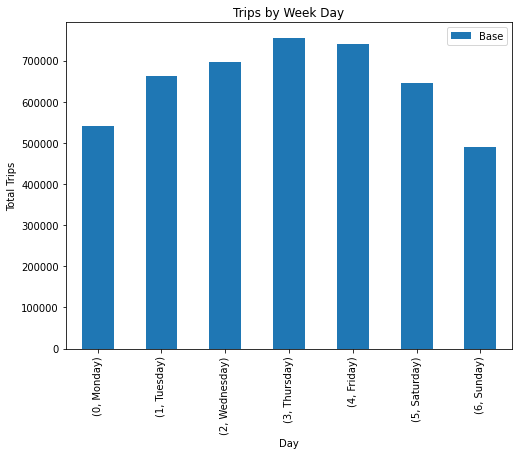

In [5]:
dataset.groupby(pd.Grouper(key='Day-of-week')).count()

uber_weekdays = dataset.pivot_table(
    index=['Day-of-week-num', 'Day-of-week'],
    values='Base',
    aggfunc='count'
)

# print(uber_weekdays)

uber_weekdays.plot(kind='bar', figsize=(8, 6))

plt.ylabel('Total Trips')
plt.xlabel('Day')
plt.title('Trips by Week Day');

We can draw the inference that the number of rides booked in a week steadily increase and the dip down on weekends. This is consistent with our common knowledge of the work week.

## Now we see the trip data by the hours

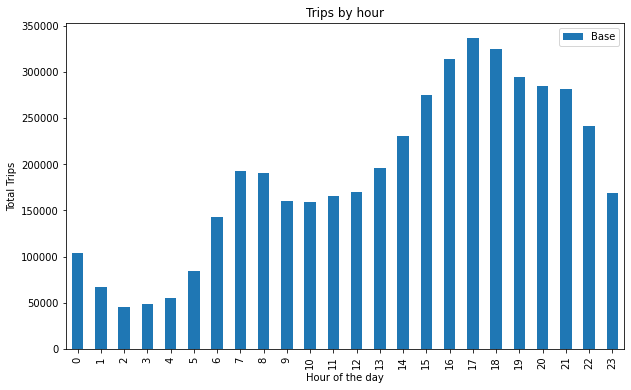

In [6]:
# Grouping the data by hour of the day
uber_hour = dataset.pivot_table(
    index=['hours'],
    values='Base',
    aggfunc='count'
)

uber_hour.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Total Trips')
plt.xlabel('Hour of the day')
plt.title('Trips by hour')
plt.show()

Again we see a pattern consistent with our knowledge of the work day. We can see a small spike in the number of uber rides around 9 AM, and the peak traffic is at 5 PM, which is commonly known as the rush hour. Early morning hours see very little traffic.

## Time series plotting

First we plot the entire data to see the number of trips on all days from April 2014 to September 2014

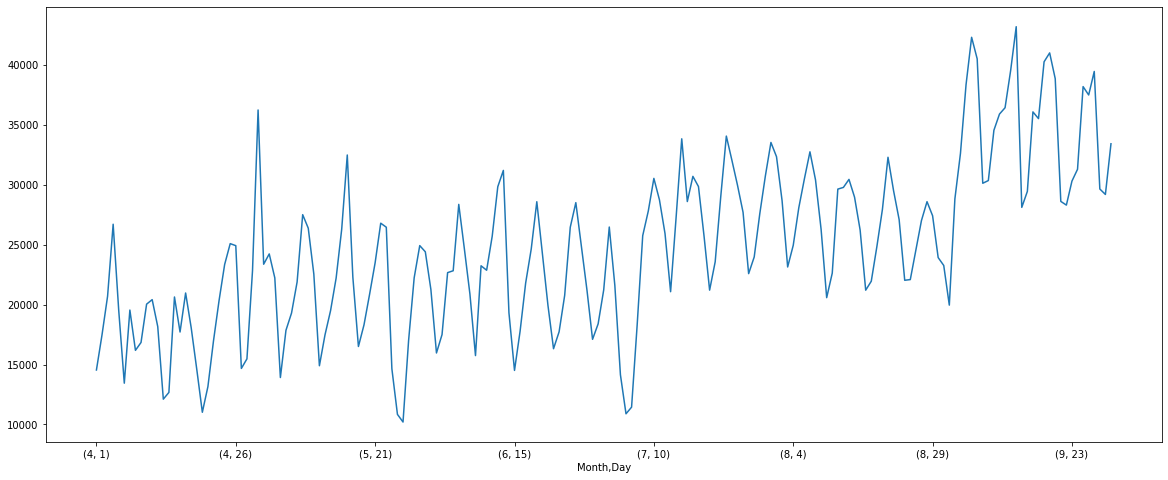

In [7]:
only_date = dataset.groupby(['Month', 'Day']).size().copy()

only_date.plot(figsize=(20, 8))
plt.show()

## Now, we will plot the data hourly to see the trends

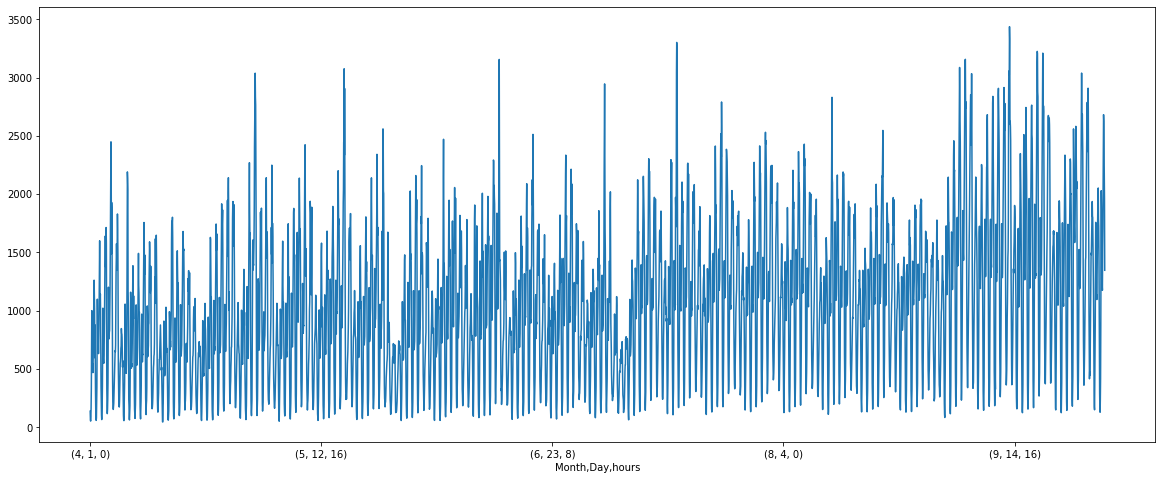

In [8]:
hourly = dataset.groupby(['Month', 'Day', 'hours']).size().copy()

hourly.plot(figsize=(20, 8))
plt.show()

# Now, we will perform stationarity tests on both of these dataframes

### Rolling mean and Rolling Standard Deviation on the date-wise dataframe

In [9]:
weekly_date_mean = only_date.rolling(window=7).mean()
weekly_date_std_deviation = only_date.rolling(window=7).std()

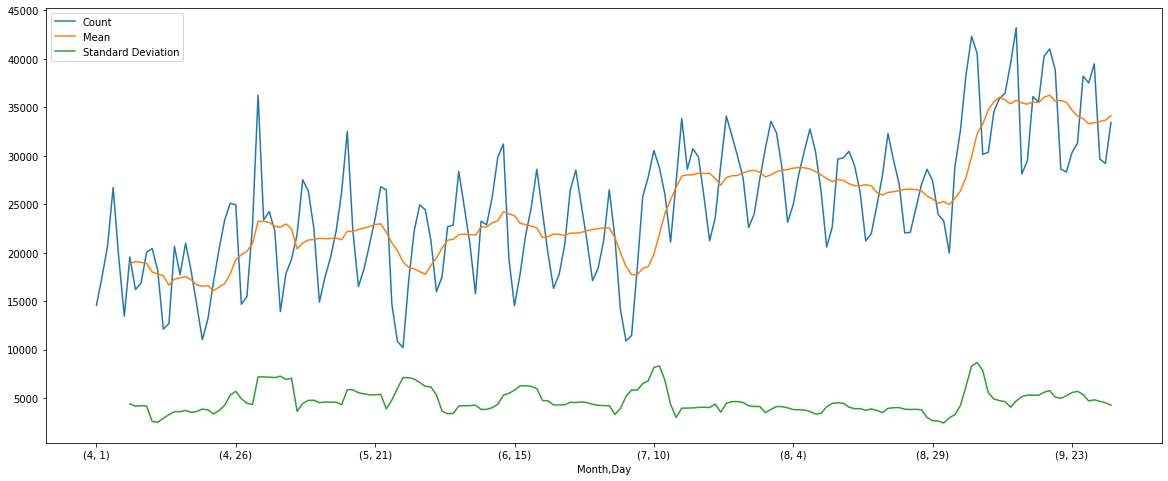

In [10]:
temp = pd.concat([only_date, weekly_date_mean, weekly_date_std_deviation], axis=1)
temp.columns = ['Count', 'Mean', 'Standard Deviation']

temp.plot(figsize=(20, 8))
plt.show()

As you can see, the dataframe does not appear to be stationary. But, just visualization is not enough, so we will perform the Augmented Dickey-Fuller test to confirm our findings.

## Augmented Dickey Fuller Test

In [11]:
date_wise_test = adfuller(only_date.values, autolag='AIC')

print('ADF Statistic: %f' % date_wise_test[0])
print('p-value: %f' % date_wise_test[1])
print('Critical Values:')
for key, value in date_wise_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.703280
p-value: 0.845898
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576


The above result confirms that we cannot reject the NULL hypothesis (that the data is non-stationary).
The p-value is a lot higher than the critical value of 0.05, and the ADF statistic is a lot lower than the 1% critical value.
Thus, we cannot reject the NULL hypothesis. This Dataframe is non-stationary

## Stationarity tests on the hourly datafram

In [12]:
daily_hour_mean = hourly.rolling(window=24).mean()
daily_hour_std_deviation = hourly.rolling(window=24).std()

weekly_hour_mean = hourly.rolling(window=24 * 7).mean()
weekly_hour_std_deviation = hourly.rolling(window=24 * 7).std()

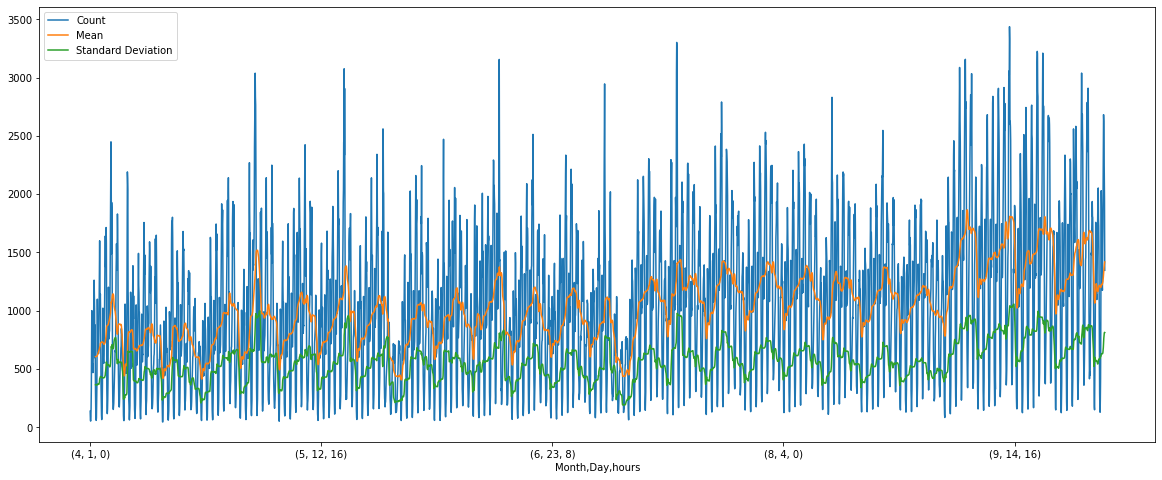

In [13]:
temp = pd.concat([hourly, daily_hour_mean, daily_hour_std_deviation], axis=1)
temp.columns = ['Count', 'Mean', 'Standard Deviation']

temp.plot(figsize=(20, 8))
plt.show()

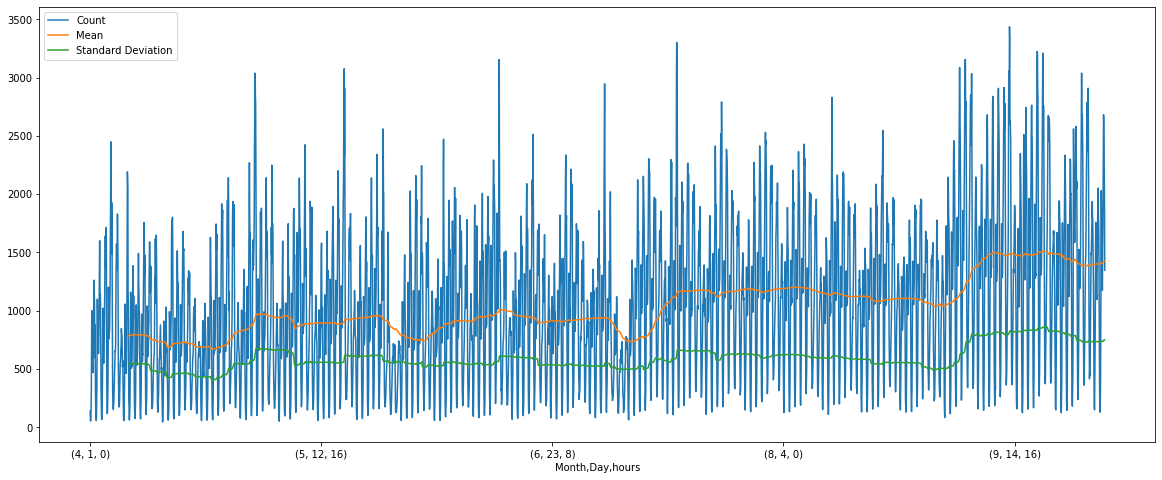

In [14]:
temp = pd.concat([hourly, weekly_hour_mean, weekly_hour_std_deviation], axis=1)
temp.columns = ['Count', 'Mean', 'Standard Deviation']

temp.plot(figsize=(20, 8))
plt.show()

In [15]:
hourly_test = adfuller(hourly.values, autolag='AIC')

print('ADF Statistic: %f' % hourly_test[0])
print('p-value: %f' % hourly_test[1])
print('Critical Values:')
for key, value in hourly_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.906253
p-value: 0.000034
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### From the above results, both graph and ADF results, we can see, that the hourly data is stationary
The ADF Statistic is lower than the 1% critical value, so we can say with atleast 99% surety that this dataframe is stationary
The p-value is also orders of magnitude lower than our last result, therefore, we will proceed with this dataframe for our forecasting

In [69]:
#Saving the dataset to a new csv file
hourly.to_csv('Minor-project-group-by-hourly.csv')